In [1]:
library(Seurat)
# library(harmony)
library(CellChat)
library(ggplot2)
library(dplyr)
library(ComplexHeatmap)
library(pheatmap)
library(ggrepel)
library(readxl)
library(gridExtra)


ggstyle = theme_bw()+theme(
            axis.line = element_line(colour = "black"),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.text.x=element_text(angle = 45, vjust = 1, hjust = 1, size=12, colour = "black"),
            axis.text.y=element_text(size=12, colour = "black"),
            text=element_text(size=12, colour = "black"),
            legend.title = element_blank(),legend.text=element_text(size=12),
            plot.title = element_text(size = 14, hjust=0.5,vjust = 0.5, 
            margin = margin(l=100,r=50,t=10,b=10),face = "bold", colour = "black"))

colmap = c('Adipocytes'= '#1f77b4',
         'Basophils'= '#aec7e8',
         'Bcells'= '#ff7f0e',
         'CD4T'='#ffbb78',
         'CD8T'= '#2ca02c',
         'Cytotoxic_T'= '#98df8a',
         'EC'= '#d62728',
         'Erythroid-like'= '#ff9896',
         'ILC2s'= '#9467bd',
         'Lymph_EC'='#c5b0d5',
         'MSC'='#8c564b',
         'Macrophages'='#c49c94',
         'NK'='#e377c2',
         'NMSC'='#f7b6d2',
         'Neutrophils'='#7f7f7f',
         'Pdgfra_APC'='#c7c7c7',
         'Pericytes'='#bcbd22',
         'Platelets'='#dbdb8d',
         'Treg'='#17becf',
         'VSM'='#9edae5')




Attaching SeuratObject

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinfor

In [2]:
## all cell
cc_ct_allcell = readRDS('../cellchat/allcell_updated_celltype_updated_cellchat.newrun.rds')


In [19]:
## plot network
netPlot = function(obj, title='', source_cell = c(), target_cell = c(), cells = c()){
    df <- as.data.frame(subsetCommunication(obj, thresh = 1))
    df.net <- subset(df, pval < 0.05)
    if (length(source_cell) != 0){
        df.net = subset(df.net, source %in% source_cell)
    }
    if (length(target_cell) != 0){
        df.net = subset(df.net, target %in% target_cell)
    }
    if (length(cells) != 0){
        df.net = subset(df.net, target %in% cells | source %in% cells)
    }
    groupSize <- as.numeric(table(c(df.net$source, df.net$target)))
    dc = as.data.frame(table(df.net[,c('source', 'target')]))
    dc = reshape2::acast(dc, formula = source ~ target)
    dc = dc[sort(rownames(dc)), sort(rownames(dc))]
    g = netVisual_circle(dc, vertex.weight = groupSize, vertex.weight.max = 1000,
                     weight.scale = T, label.edge= F, title.name = paste0(title, "\nNumber of interactions"),
                        alpha = .4, color.use = colmap)
    df.net$uniq_label = apply(df.net[,c('source', 'target', 'interaction_name')], 1, function(x){paste0(x, collapse = '~')})
    return(df)
}


In [167]:
## number of interactions in circle plot
pdf('plots/cellchat_pool_allcells/circlePlot.pdf')
res = netPlot(cc_ct_allcell, 'All Cells', source_cell = c())
dev.off()


Using Freq as value column: use value.var to override.



png 
  2

In [3]:
## total interaction
df <- as.data.frame(subsetCommunication(cc_ct_allcell, thresh = 1))
df.net <- subset(df, pval < 0.05)

df.count <- as.data.frame(table(df.net[,c('source', 'target')]))
colnames(df.count)[3] = 'InterNum'
df.count[df.count==0] = NA
# df.count$InterNum = as.integer(df.count$InterNum)
# df.count <- reshape2::acast(df.count, source ~ target) 

color.use = c("blue","red")
# color.use<-RColorBrewer::brewer.pal(n = 10, name = color.use)

g = ggplot(data = df.count) + 
    geom_point(aes(x = source, y = target, size = InterNum, color = InterNum))+
    scale_color_gradient2(midpoint = 20, high = 'red', mid = 'yellow', low = '#1C86EE')+
    theme_bw()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1.2),
            axis.text.x=element_text(angle = 45, vjust = 1, hjust = 1, size=12, colour = "black"),
            axis.text.y=element_text(size=12, colour = "black"),
                text=element_text(size=12, colour = "black"),
            legend.title = element_blank(),legend.text=element_text(size=12),
            plot.title = element_text(size = 14, hjust=0.5,vjust = 0.5, 
            margin = margin(l=100,r=50,t=10,b=10),face = "bold", colour = "black"))+
    xlab('Sender')+ylab('Receiver')

pdf('plots/cellchat_pool_allcells/interaction_dotplot.pdf', width = 7, height = 5)
print(g)
dev.off()



In [8]:
## number of interaction for each cell type
source_df = as.data.frame(table(df.net[,c('source')]))
# reshape2::melt(plot_df, value.name = 'Freq')
source_df$Type = 'Sender'
target_df = as.data.frame(table(df.net[,c('target')]))
# reshape2::melt(plot_df, value.name = 'Freq')
target_df$Type = 'Receiver'

plot_df = rbind(source_df, target_df)
colnames(plot_df) = c('Cell_type', 'Count', 'Type')
g = ggplot(data = plot_df,
       aes(x = reorder(Cell_type, -Count), y = Count, fill = Type))+
       geom_bar(stat = 'identity', position = position_dodge(width = .9))+ggstyle+
    scale_fill_manual(values = c('Sender'='navy', 'Receiver'='darkred'))+
    xlab('')+ylab('Number of Communications')
pdf('plots/cellchat_pool_allcells/commu_count_by_celltype.pdf', width = 6.5, height = 5)
print(g)
dev.off()


In [6]:
## different type of interactions
cc_ct_allcell.df <- as.data.frame(subsetCommunication(cc_ct_allcell, thresh = 1))
cc_ct_allcell.df.sign = as.data.frame(as.matrix(subset(cc_ct_allcell.df, pval < 0.05)))

df <- cc_ct_allcell.df.sign %>% 
  group_by(annotation) %>% # Variable to be transformed
  count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

pdf('plots/cellchat_pool_allcells/communication_type.pdf', width = 4, height = 4)
g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
  geom_col(color = "black") +
  geom_label(aes(label = labels), color = c("white", 1, 1),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  guides(fill = guide_legend(title = "Communication Type")) +
  scale_fill_viridis_d() +
  coord_polar(theta = "y") + 
  theme_void()+labs(title = 'Prediction')
print(g)
dev.off()

## interaction type in background (CellChatDB)

df <- cc_ct_allcell@DB$interaction %>% 
  group_by(annotation) %>% # Variable to be transformed
  count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

pdf('plots/cellchat_pool_allcells/communication_type_database.pdf', width = 4, height = 4)
g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
  geom_col(color = "black") +
  geom_label(aes(label = labels), color = c("white", 1, 1),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  guides(fill = guide_legend(title = "Communication Type")) +
  scale_fill_viridis_d() +
  coord_polar(theta = "y") + 
  theme_void()+labs(title = 'Background')
print(g)
dev.off()



## compare conditions

In [17]:
cellchat_all.new = readRDS('../cellchat/allcell_updated_celltype_cond_updated_cellchat.newrun.rds')
df <- as.data.frame(subsetCommunication(cellchat_all.new, thresh = 1))
df$source_cond = do.call(rbind, strsplit(as.vector(df$source), '\\~'))[,2]
df$target_cond = do.call(rbind, strsplit(as.vector(df$target), '\\~'))[,2]
df = subset(df, source_cond == target_cond)
## remove adipocytes in TN, RT, and cold7, their number of cells less than 50
remove_cells = c('Adipocytes~TN', 'Adipocytes~RT', 'Adipocytes~cold7')
df = subset(df, !source %in% remove_cells & !target %in% remove_cells)


In [6]:
table(cellchat_all.new@meta[,c('cond', 'cell_type')])


       cell_type
cond    Adipocytes Basophils Bcells  CD4T  CD8T Cytotoxic_T    EC
  RT            49       147   7751  1801  1690         369  1537
  TN             3       191  10508  2758  3258        1041  2173
  cold2        948       285  14929  2411  2466         751  1339
  cold7         27       154   9075  1776  2009         375   634
       cell_type
cond    Erythroid-like ILC2s Lymph_EC   MSC Macrophages    NK  NMSC Neutrophils
  RT               387   219       90   181         468   983   156         251
  TN               398    88       81    87        1110  1896   186         328
  cold2            662   189      172   223         959  2355   290         680
  cold7            640   109      103    94         425  1609   315         224
       cell_type
cond    Pdgfra_APC Pericytes Platelets  Treg   VSM
  RT           420       172       116   244  5095
  TN           774       219        72   848  6087
  cold2       1079       255       279   382  2816
  cold7        

In [3]:
## circle plot for each condition
pdf('plots/cellchat_condition_allcells/CellChat_NetPlot_updated.pdf')
LR_net = list()
for (condition in c('TN', 'RT', 'cold2', 'cold7')){
    title=condition
    tdf = subset(df, source_cond == condition & target_cond == condition & pval < 0.05)
    tdf$source = gsub(paste0('~', condition), '', tdf$source)
    tdf$target = gsub(paste0('~', condition), '', tdf$target)
    if (condition != 'cold2'){
        tdf$source = factor(tdf$source, levels = sort(c(unique(tdf$source), 'Adipocytes')))
        tdf$target = factor(tdf$target, levels = sort(c(unique(tdf$target), 'Adipocytes')))
    }
#     tdf = as.data.frame(as.matrix(tdf))
    groupSize <- table(c(tdf$source, tdf$target))
    dc = as.data.frame(table(tdf[,c('source', 'target')]))
    dc = reshape2::acast(dc, formula = source ~ target)
    dc = dc[sort(rownames(dc)), sort(rownames(dc))]
    colnames(dc) = gsub(paste0('~', condition), '', colnames(dc))
    rownames(dc) = gsub(paste0('~', condition), '', rownames(dc))
    ##
    if (condition != 'cold2'){
        dc = dc[-which(rownames(dc) == 'Adipocytes'), -which(colnames(dc) == 'Adipocytes')]
    }
    g = netVisual_circle(dc, vertex.weight = groupSize[rownames(dc)], vertex.weight.max = 1000,
                     weight.scale = T, label.edge= F, title.name = paste0(title, "\nNumber of interactions"),
                        alpha = .4, color.use = colmap[rownames(dc)])#[unique(c(tdf$source, tdf$target))])
    LR_net[[condition]] = tdf
}
dev.off()




Using Freq as value column: use value.var to override.

Using Freq as value column: use value.var to override.

Using Freq as value column: use value.var to override.

Using Freq as value column: use value.var to override.



png 
  2

In [173]:
## how many out-going for each celltype in conditions
outgoing_count = do.call(rbind, lapply(LR_net, function(df) table(df$source)))
chi_t = p.adjust(apply(outgoing_count, 2, function(x){chisq.test(x)$p.value}))
chi_t = format(chi_t, digits = 2, scientific = T)
outgoing_count_plot = outgoing_count
rownames(outgoing_count_plot) = c('TN', 'RT', 'Cold_2', 'Cold_7')
colnames(outgoing_count_plot) = sapply(colnames(outgoing_count_plot), function(x){
        paste0(x, ' [p=', chi_t[x], ']')
})                              
                                       
incoming_count = do.call(rbind, lapply(LR_net, function(df) table(df$target)))
chi_t = p.adjust(apply(incoming_count, 2, function(x){chisq.test(x)$p.value}))
chi_t = format(chi_t, digits = 2, scientific = T)
incoming_count_plot = incoming_count
rownames(incoming_count_plot) = c('TN', 'RT', 'Cold_2', 'Cold_7')
colnames(incoming_count_plot) = sapply(colnames(incoming_count_plot), function(x){
    paste0(x, ' [p=', chi_t[x], ']')
})                              
                      
col_fun = circlize::colorRamp2(c(0, 50, 100, 400, 600, 900), c('grey', 'pink', 'purple', 
                                                               'blue', 'darkorange', 'red'))
#                                rev(c(rainbow(6)[2:6], 'grey')))
              
pdf('plots/cellchat_condition_allcells/outgoing_incoming_commu_count_ht.pdf', height = 6, width = 7)
Heatmap(t(outgoing_count_plot), name = "Outgoing Interaction", cluster_columns = F, cluster_rows = T, col = col_fun,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%.0f", t(outgoing_count_plot)[i, j]), x, y, gp = gpar(fontsize = 8, col = 'white'))}, 
        rect_gp = gpar(col = "white", lwd = 1),
       top_annotation = HeatmapAnnotation('Total' = row_anno_barplot(colSums(t(outgoing_count_plot))))
       )
    
Heatmap(t(incoming_count_plot), name = "Incoming Interaction", cluster_columns = F, cluster_rows = T, col = col_fun,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%.0f", t(incoming_count_plot)[i, j]), x, y, gp = gpar(fontsize = 8, col = 'white'))}, 
        rect_gp = gpar(col = "white", lwd = 1),
       top_annotation = HeatmapAnnotation('Total' = row_anno_barplot(colSums(t(incoming_count_plot))))
       )
dev.off()
         


png 
  2

In [191]:
## only total number of  interactions
dat = data.frame('outgoing'=colSums(t(outgoing_count_plot)), 
           'incoming'=colSums(t(incoming_count_plot)))
write.table(dat, file = 'plots/cellchat_condition_allcells/outgoing_incoming_commu_number.tsv',
          sep = '\t', quote = F)



In [193]:
chisq.test(dat$outgoing)



	Chi-squared test for given probabilities

data:  dat$outgoing
X-squared = 589.28, df = 3, p-value < 2.2e-16


In [18]:
## significant communication in any condition
df.sig = subset(df, pval < 0.05)
df.sig$Sender = sapply(as.vector(df.sig$source), function(x) {strsplit(x, '\\~')[[1]][1]})
df.sig$Receiver = sapply(as.vector(df.sig$target), function(x) {strsplit(x, '\\~')[[1]][1]})

df.sig$cell_pair = apply(df.sig[,c('Sender', 'interaction_name', 'Receiver')], 1, function(x) paste0(x, collapse = ' -> '))

                         

In [176]:
### communication type for each condition
pdf('plots/cellchat_condition_allcells/communication_type_cond.pdf', width = 4, height = 4)

for (i in unique(df.sig$source_cond)){
    dftmp <- subset(df.sig, source_cond == i) %>% 
      group_by(annotation) %>% # Variable to be transformed
      count() %>% 
      ungroup() %>% 
      mutate(perc = `n` / sum(`n`)) %>% 
      arrange(perc) %>%
      mutate(labels = scales::percent(perc))

    g = ggplot(dftmp, aes(x = "", y = perc, fill = annotation)) +
      geom_col(color = "black") +
      geom_label(aes(label = labels), color = c("white", 1, 1),
                position = position_stack(vjust = 0.5),
                show.legend = FALSE) +
      guides(fill = guide_legend(title = "Communication Type")) +
      scale_fill_viridis_d() +
      coord_polar(theta = "y") + 
      theme_void()+labs(title = i)
    print(g)
}
dev.off()



png 
  2

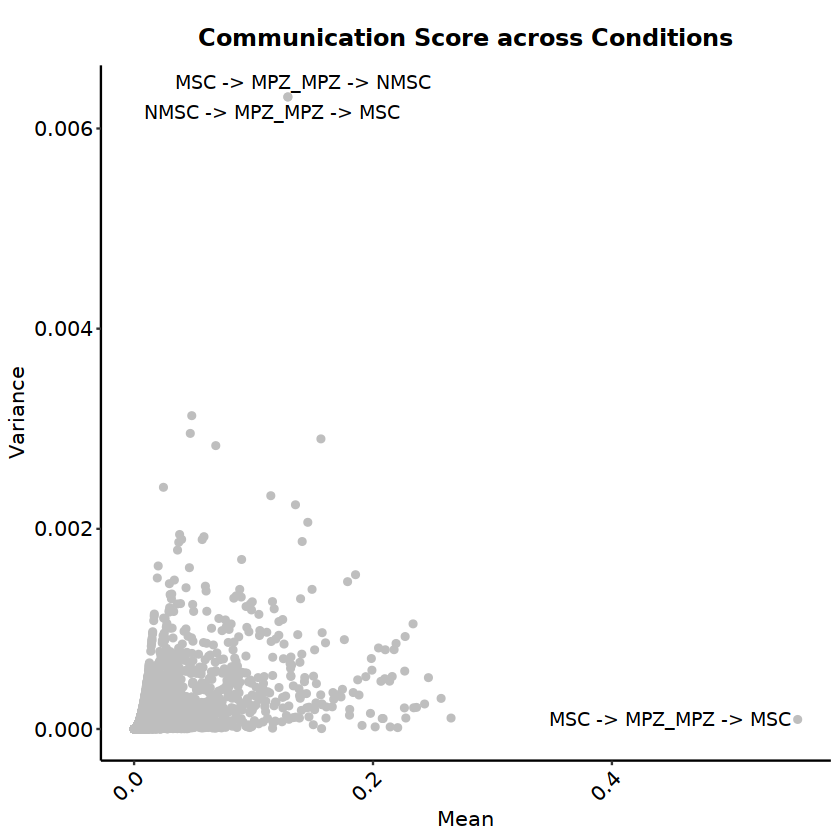

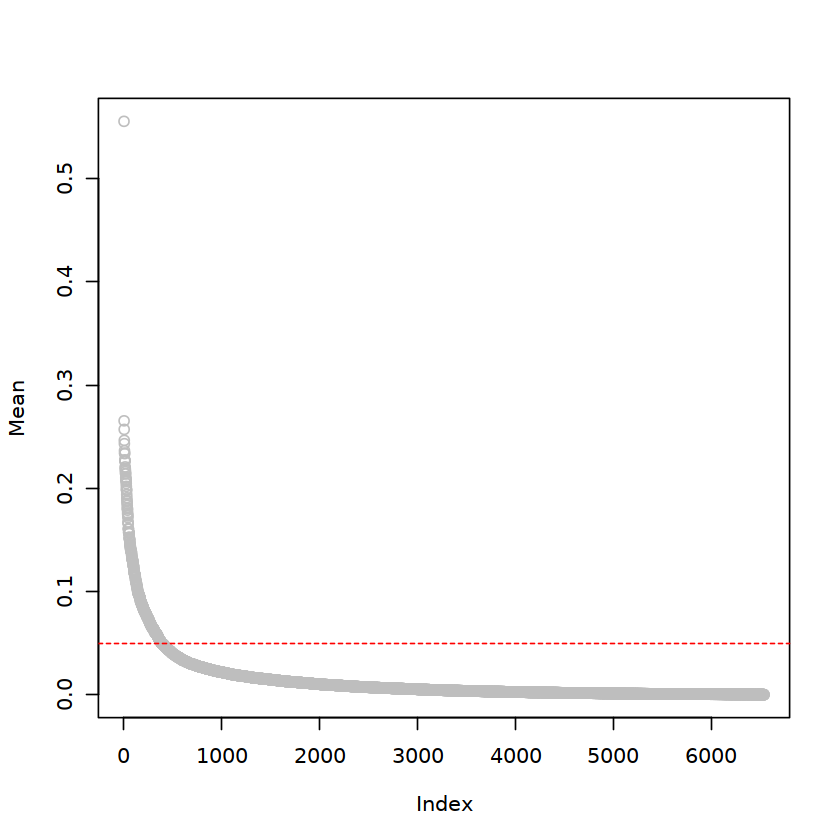

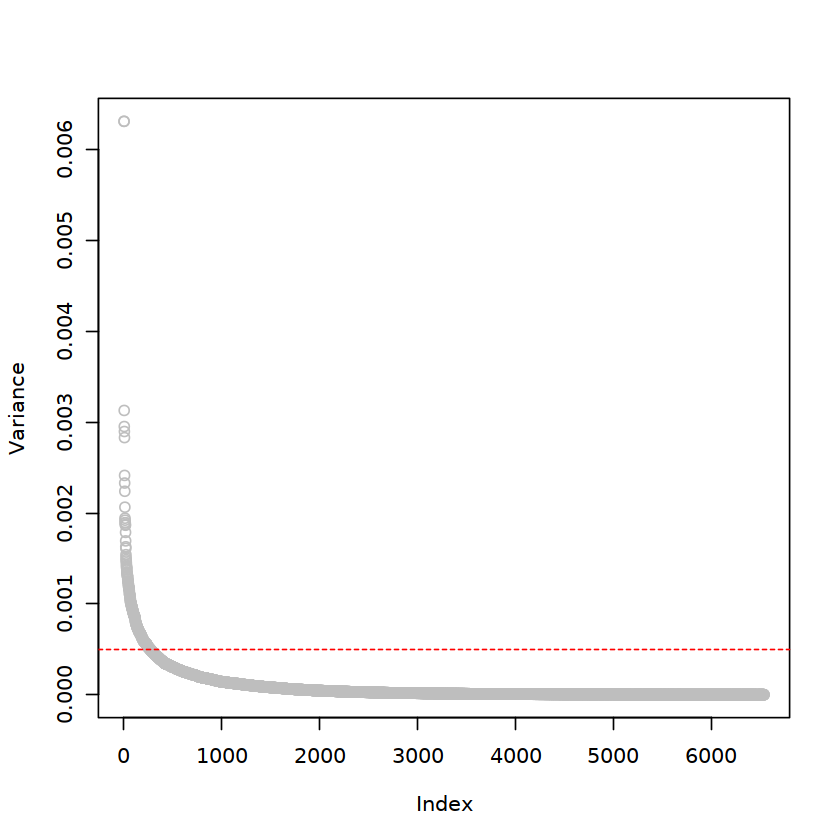

In [19]:
## matrix of communication from original
df$Sender = sapply(as.vector(df$source), function(x) {strsplit(x, '\\~')[[1]][1]})
df$Receiver = sapply(as.vector(df$target), function(x) {strsplit(x, '\\~')[[1]][1]})

df$cell_pair = apply(df[,c('Sender', 'interaction_name', 'Receiver')], 1, function(x) paste0(x, collapse = ' -> '))
                     
## to matrix, fill 0 if not recorded
comm_mat = reshape2::acast(df[,c('source_cond', 'prob', 'cell_pair')],
                           formula = cell_pair ~ source_cond,
                           value.var = 'prob', fill = 0)

## only commu for at least significant in one condition
index = rownames(comm_mat)[rownames(comm_mat) %in% as.vector(df.sig$cell_pair)]
comm_mat = comm_mat[index,]
comm_mat = comm_mat[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat = apply(comm_mat, 2, function(x) as.numeric(x))
rownames(comm_mat) = index
                 
## mean vs variance
comm_mat_stat = data.frame('m' = apply(comm_mat, 1, mean), 'v' = apply(comm_mat, 1, var),
          'commu' = rownames(comm_mat))

### plots to decide cutoff to select most variable communications
g = ggplot(data = comm_mat_stat)+
    geom_point(aes(x = m, y = v), color = 'grey')+ggstyle+
    xlab('Mean')+ylab('Variance')+labs(title = 'Communication Score across Conditions')+
    geom_text_repel(data = subset(comm_mat_stat, m > 0.4 | v > 0.004),
                   aes(x = m, y = v, label = commu))
    
# pdf('commu_var_mean.pdf', height = 5, width = 5)
print(g)
plot(sort(comm_mat_stat$m, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Mean')
abline(h = 0.05, col = 'red', lty = 2)
plot(sort(comm_mat_stat$v, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Variance')
abline(h = 0.0005, col = 'red', lty = 2)
                 
                 

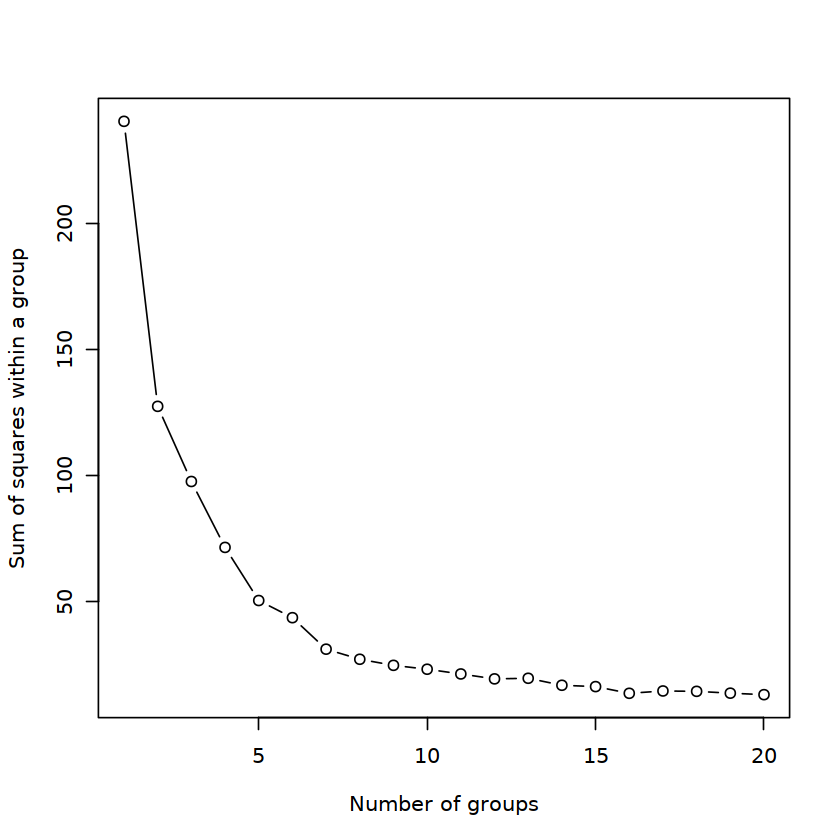

In [20]:
## kmeans for the most variable communications
var_cutoff = 0.0005
mean_cutoff = 0.05
var_cell_pair = sort(rownames(subset(comm_mat_stat, v >= var_cutoff & m >= mean_cutoff)))
## remove adipocytes, since it only included in cold2
var_cell_pair = var_cell_pair[!grepl('Adipocytes', var_cell_pair)]

var_comm = comm_mat[var_cell_pair,]
var_comm_scale = scale(t(var_comm))
## determine k
wssplot <- function(data, nc=15, seed=123){
               wss <- (nrow(data)-1)*sum(apply(data,2,var))
               for (i in 2:nc){
                    set.seed(seed)
                    wss[i] <- sum(kmeans(data, centers=i)$withinss)}
                plot(1:nc, wss, type="b", xlab="Number of groups",
                     ylab="Sum of squares within a group")}

wssplot(t(var_comm_scale), nc = 20)




In [8]:
## decide k = 5
# k = 5
# kmeans_res = kmeans(t(var_comm_scale), 5, nstart = 10000)
# saveRDS(kmeans_res, file = 'most_var_commu_kmeans_withoutAdipocyte.rds')
kmeans_res = readRDS('most_var_commu_kmeans_withoutAdipocyte.rds')
commu_order = sort(kmeans_res$cluster)

pdf('plots/cellchat_condition_allcells/condition_variable_commu_heatmap.pdf', height = 6, width = 15)
commu_order = sort(kmeans_res$cluster)
cols = list(Sender = colmap, Receiver = colmap)

Heatmap(var_comm_scale[,names(commu_order)],
        name = 'Communication\nStrength',
        column_split = commu_order,
        cluster_columns = F,
        cluster_rows = F,
        rect_gp = gpar(col = "white", lwd = .5),
        column_names_gp = gpar(fontsize = 7),
        top_annotation = HeatmapAnnotation('Sender'=sapply(names(commu_order), function(x) {strsplit(x, ' -> ')[[1]][1]}),
                                          'Receiver'=sapply(names(commu_order), function(x) {strsplit(x, ' -> ')[[1]][3]}),
                                          col = cols)
       )
dev.off()


In [178]:
## a subset of patterns, pattern 2, 5, 4
pdf('plots/cellchat_condition_allcells/condition_variable_commu_heatmap_subset.pdf', height = 6, width = 12)

commu_order = sort(kmeans_res$cluster)

need_comm = commu_order[commu_order %in% c(1, 2, 5)]

cols = list(Sender = colmap, Receiver = colmap)

Heatmap(var_comm_scale[,names(need_comm)],
        name = 'Communication\nStrength',
        column_split = paste0('Pattern ', as.character(need_comm)),
        cluster_columns = F,
        cluster_rows = F,
        rect_gp = gpar(col = "white", lwd = .5),
        column_names_gp = gpar(fontsize = 7),
        top_annotation = HeatmapAnnotation('Sender'=sapply(names(need_comm), function(x) {strsplit(x, ' -> ')[[1]][1]}),
                                          'Receiver'=sapply(names(need_comm), function(x) {strsplit(x, ' -> ')[[1]][3]}),
                                          col = cols)
       )
dev.off()



png 
  2

In [179]:
### pattern of communication score

pdf('plots/cellchat_condition_allcells/communication_score_pattern.pdf', width = 3, height = 3)
cols = c('red', 'blue', 'orange', 'purple', 'black')
for (p in 1:5){
    commus = commu_order[commu_order == p]
    dat = var_comm[names(commus),]
    plot_df = data.frame('commu'=rowMeans(t(dat)),
                        'cond' = factor(colnames(var_comm), levels = c('TN', 'RT', 'cold2', 'cold7')),
                        'low' = apply(dat, 2, min),
                        'high' = apply(dat, 2, max))

    g = ggplot(plot_df, aes(x = cond, y = commu, group = 1)) + 
          geom_line(col=cols[p], linetype = 'dashed') + 
          geom_point(col=cols[p], size = 4) + 
          geom_ribbon(aes(ymin = low, ymax = high), alpha = 0.1)+ggstyle+
          xlab('')+ylab('Communication Score')+labs(title = paste0('Pattern ', p))
    print(g)
}
dev.off()


png 
  2

In [180]:
## cell type proportion for patterns
pdf('plots/cellchat_condition_allcells/pattern_sender_proportion.pdf', width = 6, height = 6)
for (p in 1:5){
    cellpair = names(commu_order[commu_order == p])
    sender = do.call(c, lapply(strsplit(cellpair, '\\ -> '), function(x){x[1]}))
    count_table = table(sender)
    col = colmap[names(count_table)]
    names(count_table) = paste0(names(count_table),' (', round(count_table * 100 / sum(count_table), 2), '%)')
    par(mar=c(4,6.5,4,6))
    pie(count_table, col = col,
        main = paste0('Pattern ', p))
}
dev.off()


pdf('plots/cellchat_condition_allcells/pattern_receiver_proportion.pdf', width = 6, height = 6)
for (p in 1:5){
    cellpair = names(commu_order[commu_order == p])
    sender = do.call(c, lapply(strsplit(cellpair, '\\ -> '), function(x){x[3]}))
    count_table = table(sender)
    col = colmap[names(count_table)]
    names(count_table) = paste0(names(count_table),' (', round(count_table * 100 / sum(count_table), 2), '%)')
    par(mar=c(4,6.5,4,6))
    pie(count_table, col = col,
        main = paste0('Pattern ', p))
}
dev.off()


png 
  2

png 
  2

In [182]:

pdf('plots/cellchat_condition_allcells/pattern_commu_type_proportion.pdf', width = 4, height = 4)
cols = c('Cell-Cell Contact'="white", 
        'ECM-Receptor'=1,
        'Secreted Signaling'=1)
fillcols = c('Cell-Cell Contact'="#440154FF", 
        'ECM-Receptor'='#21908CFF',
        'Secreted Signaling'='#FDE725FF')
for (p in 1:5){
    cellpair = names(commu_order[commu_order == p])
    lr = do.call(c, lapply(strsplit(cellpair, '\\ -> '), function(x){x[2]}))
    lr_type = cellchat_all.new@DB$interaction[lr,]#'annotation']
    df <- lr_type %>% 
      group_by(annotation) %>% # Variable to be transformed
      count() %>% 
      ungroup() %>% 
      mutate(perc = `n` / sum(`n`)) %>% 
      arrange(perc) %>%
      mutate(labels = scales::percent(perc))
    df = df[order(df$annotation),]
    g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
      geom_col(color = "black") +
      geom_label(aes(label = labels), color = cols[df$annotation],
                position = position_stack(vjust = 0.5),
                show.legend = FALSE) +
      guides(fill = guide_legend(title = "Communication Type")) +
    scale_fill_manual(values = fillcols)+
      coord_polar(theta = "y") + 
      theme_void()+labs(title = paste0('Pattern ', p))
    print(g)

}
dev.off()



png 
  2

In [22]:
### differential expression

diffexp = read_excel('./data/diffexp_scBAT_condpair_celltype.xlsx', sheet = 'all sheet combined')
diffexp$name_upper = toupper(diffexp$names)
diffexp = as.data.frame(diffexp)
diffexp$label = apply(diffexp[,c('cell_type', 'names')], 1, function(x){paste0(x, collapse = '~')})



In [23]:
## diffexp for ligand

LRsig = cellchat_all.new@LR$LRsig

ligand_lfc_coll = NULL
ligand_padj_coll = NULL
sender_label_coll = NULL
for (i in rownames(var_comm)){
    i = strsplit(i, '\\ -> ')[[1]]
    sender = i[1]
    interction = i[2]
    ligand = toupper(LRsig[interction,'ligand'])
    label.tmp = paste0(sender, '~', ligand)
    sender_label_coll = c(sender_label_coll, label.tmp)
}
sender_label_coll = unique(sender_label_coll)


for (i in sender_label_coll){
    i = strsplit(i, '\\~')[[1]]
    sender = i[1]
    ligand = i[2]
#     d = diffexp[diffexp$cell_type == sender & diffexp$name_upper == ligand,]
    d = diffexp[diffexp$name_upper == ligand,]
    lfc = reshape2::acast(d, formula = label ~ compare, value.var = 'logfoldchanges')
    ligand_lfc_coll = rbind(ligand_lfc_coll, lfc)
    padj = reshape2::acast(d, formula = label ~ compare, value.var = 'pvals_adj')
    ligand_padj_coll = rbind(ligand_padj_coll, padj)
}

## receptor
receptor_lfc_coll = NULL
receptor_padj_coll = NULL
receiver_label_coll = NULL
for (i in rownames(var_comm)){
    i = strsplit(i, '\\ -> ')[[1]]
    receiver = i[3]
    interction = i[2]
    receptor = strsplit(LRsig[interction,'interaction_name_2'], '\\ - ')[[1]][2]
    receptor = strsplit(gsub('\\(|)', '', receptor), '\\+')[[1]]
    label.tmp = sapply(receptor, function(x) paste0(receiver, '~', toupper(x)))
    receiver_label_coll = c(receiver_label_coll, label.tmp)
}
receiver_label_coll = unique(receiver_label_coll)

for (i in receiver_label_coll){
    i = strsplit(i, '\\~')[[1]]
    receiver = i[1]
    receptor = i[2]
#     d = diffexp[diffexp$cell_type == receiver & diffexp$name_upper == receptor,]
    d = diffexp[diffexp$name_upper == receptor,]
    lfc = reshape2::acast(d, formula = label ~ compare, value.var = 'logfoldchanges')
    receptor_lfc_coll = rbind(receptor_lfc_coll, lfc)
    padj = reshape2::acast(d, formula = label ~ compare, value.var = 'pvals_adj')
    receptor_padj_coll = rbind(receptor_padj_coll, padj)
}

ligands = unique(sapply(rownames(ligand_lfc_coll), function(x){strsplit(x, '\\~')[[1]][2]}))
ligand_mean = apply(as.matrix(cellchat_all.new@data[ligands,]), 1, function(x) tapply(x, cellchat_all.new@meta$cell_type_new, mean))
ligand_mean = as.data.frame(reshape2::melt(ligand_mean))
colnames(ligand_mean) = c('Cell_Cond', 'Gene', 'Expression')
ligand_mean$Cell = sapply(as.vector(ligand_mean$Cell_Cond), function(x) strsplit(x, '\\~')[[1]][1])
ligand_mean$Cond = sapply(as.vector(ligand_mean$Cell_Cond), function(x) strsplit(x, '\\~')[[1]][2])
ligand_mean$Label = apply(ligand_mean, 1, function(x){
    paste0(x['Cell'],'~',x['Gene'])
})
ligand_mean = reshape2::acast(ligand_mean, Label ~ Cond, value.var = 'Expression')                               
                    
receptors = unique(sapply(rownames(receptor_lfc_coll), function(x){strsplit(x, '\\~')[[1]][2]}))
receptor_mean = apply(as.matrix(cellchat_all.new@data[receptors,]), 1, function(x) tapply(x, cellchat_all.new@meta$cell_type_new, mean))
receptor_mean = as.data.frame(reshape2::melt(receptor_mean))
colnames(receptor_mean) = c('Cell_Cond', 'Gene', 'Expression')
receptor_mean$Cell = sapply(as.vector(receptor_mean$Cell_Cond), function(x) strsplit(x, '\\~')[[1]][1])
receptor_mean$Cond = sapply(as.vector(receptor_mean$Cell_Cond), function(x) strsplit(x, '\\~')[[1]][2])
receptor_mean$Label = apply(receptor_mean, 1, function(x){
    paste0(x['Cell'],'~',x['Gene'])
})
receptor_mean = reshape2::acast(receptor_mean, Label ~ Cond, value.var = 'Expression')                               
      
                  

In [24]:
### expression status of ligand and receptor in patterns

cols = c('red', 'blue', 'orange', 'purple', 'black')

pdf('plots/cellchat_condition_allcells/pattern_ligand_receptor_exp.pdf', width = 4.5, height = 5)

sender_receiver_pair = NULL

for (p in 1:5){
# p = 1
sender_ligand = NULL
receiver_receptor= NULL

for (i in names(commu_order[commu_order == p])){
    i = strsplit(i, '\\ -> ')[[1]]
    sender = i[1]
    interction = i[2]
    l = toupper(LRsig[interction,'ligand'])
    sp = paste0(sender, '~', l)
    sender_ligand = c(sender_ligand, sp)
    ##
    receiver = i[3]
    r = strsplit(LRsig[interction,'interaction_name_2'], '\\ - ')[[1]][2]
    r = strsplit(gsub('\\(|)', '', r), '\\+')[[1]]
    rp = paste0(receiver, '~', r)
    receiver_receptor = c(receiver_receptor, rp)
#     senders = c(senders, cell)
#     ligand = c(ligand, l)
    sender_receiver_pair = rbind(sender_receiver_pair, data.frame('sender'=sp, 'receiver'=rp, 'pattern' = p))
}
sender_ligand = unique(sender_ligand)
receiver_receptor = unique(receiver_receptor)

## mean exp
ligand_mean.new = ligand_mean[toupper(rownames(ligand_mean)) %in% toupper(sender_ligand),]
plot_df.legand = data.frame('Cond' = factor(colnames(ligand_mean.new), levels = c('TN', 'RT', 'cold2', 'cold7')),
                           'mean_exp' = colMeans(ligand_mean.new),
                           'high' = apply(ligand_mean.new, 2, function(x) quantile(x, 0.85)),
                           'low' = apply(ligand_mean.new, 2, function(x) quantile(x, 0.15)))
plot_df.legand$Type = 'Ligand in Senders'


receptor_mean.new = receptor_mean[toupper(rownames(receptor_mean)) %in% toupper(receiver_receptor),]
plot_df.receptor= data.frame('Cond' = factor(colnames(receptor_mean.new), levels = c('TN', 'RT', 'cold2', 'cold7')),
                           'mean_exp' = colMeans(receptor_mean.new),
                           'high' = apply(receptor_mean.new, 2, function(x) quantile(x, 0.85)),
                           'low' = apply(receptor_mean.new, 2, function(x) quantile(x, 0.15)))
plot_df.receptor$Type = 'Receptor in Receivers'


##
dotcolor = c('Ligand in Senders'='#FF3E96', 'Receptor in Receivers'='#1C86EE')
plot_df = rbind(plot_df.legand, plot_df.receptor)
g = ggplot(plot_df, aes(x = Cond, y = mean_exp, group = 1)) + 
          geom_line(data = subset(plot_df, Type == 'Ligand in Senders'), col=cols[p], linetype = 'dashed') + 
          geom_point(aes(shape = Type, color = Type), size = 4)+
          geom_line(data = subset(plot_df, Type == 'Receptor in Receivers'), col=cols[p], linetype = 'dashed') +
          geom_ribbon(data = subset(plot_df, Type == 'Receptor in Receivers'), 
                      aes(ymin = low, ymax = high), fill = dotcolor['Receptor in Receivers'], alpha = 0.05)+
          geom_ribbon(data = subset(plot_df, Type == 'Ligand in Senders'), 
                      aes(ymin = low, ymax = high), fill = dotcolor['Ligand in Senders'], alpha = 0.05)+
            ggstyle+ scale_color_manual(values = dotcolor)+
          xlab('')+ylab('Mean Expression in Cell Type')+labs(title = paste0('Pattern ', p))+
          theme(legend.position="bottom")+guides(fill=guide_legend(ncol=2))
print(g)    
}                           
dev.off()
                                         
                                         

png 
  2

In [51]:
## ligand
## sender_pattern
tmp=sender_receiver_pair[!duplicated(sender_receiver_pair$sender),]
tmp = subset(tmp, pattern %in% c(1, 2, 5))
sender_pattern = as.vector(tmp$pattern)
names(sender_pattern) = toupper(as.vector(tmp$sender))

index = toupper(rownames(ligand_lfc_coll)) %in% toupper(unique(sender_receiver_pair$sender))

legend_lfc_df = reshape2::melt(ligand_lfc_coll[index,])
colnames(legend_lfc_df) = c('Cell_Ligand', 'Comparison', 'LFC')
legend_lfc_df$padj = apply(legend_lfc_df, 1, function(x){ligand_padj_coll[x[1], x[2]]})
legend_lfc_df$p.label = ifelse(legend_lfc_df$padj <= 0.05, yes = 'padj <= 0.05', no = 'padj > 0.05')
legend_lfc_df = subset(legend_lfc_df, Comparison %in% c('RT~vs~TN', 'cold2~vs~TN', 'cold7~vs~TN'))
legend_lfc_df$Comparison = factor(legend_lfc_df$Comparison, 
                                  levels = c('RT~vs~TN', 'cold2~vs~TN', 'cold7~vs~TN'))
#                                   c('RT~vs~TN', 'cold2~vs~RT', 'cold2~vs~TN',
#                                     'cold7~vs~cold2', 'cold7~vs~RT','cold7~vs~TN'))
legend_lfc_df$pattern = sender_pattern[toupper(as.vector(legend_lfc_df$Cell_Ligand))]

sig.legand = unique(as.vector(subset(legend_lfc_df, padj <= 0.05)$Cell_Ligand))

## receptor
## sender_pattern
tmp=sender_receiver_pair[!duplicated(sender_receiver_pair$receiver),]
tmp = subset(tmp, pattern %in% c(1, 2, 5))
receiver_pattern = as.vector(tmp$pattern)
names(receiver_pattern) = toupper(as.vector(tmp$receiver))


index = toupper(rownames(receptor_lfc_coll)) %in% toupper(unique(sender_receiver_pair$receiver))
receptor_lfc_df = reshape2::melt(receptor_lfc_coll[index,])
colnames(receptor_lfc_df) = c('Cell_Receptor', 'Comparison', 'LFC')
receptor_lfc_df$padj = apply(receptor_lfc_df, 1, function(x){receptor_padj_coll[x[1], x[2]]})
receptor_lfc_df$p.label = ifelse(receptor_lfc_df$padj <= 0.05, yes = 'padj <= 0.05', no = 'padj > 0.05')
receptor_lfc_df = subset(receptor_lfc_df, Comparison %in% c('RT~vs~TN', 'cold2~vs~TN', 'cold7~vs~TN'))

receptor_lfc_df$Comparison = factor(receptor_lfc_df$Comparison, 
                                    levels = c('RT~vs~TN', 'cold2~vs~TN', 'cold7~vs~TN'))
#                                     c('RT~vs~TN', 'cold2~vs~RT','cold2~vs~TN',
#                                       'cold7~vs~cold2','cold7~vs~RT','cold7~vs~TN'))
receptor_lfc_df$pattern = receiver_pattern[toupper(as.vector(receptor_lfc_df$Cell_Receptor))]

sig.receptor = unique(as.vector(subset(receptor_lfc_df, padj <= 0.05)$Cell_Receptor))


# ## significant in at least one comparison
sig.pair = subset(sender_receiver_pair, toupper(sender) %in% toupper(sig.legand) | 
                                          toupper(receiver) %in% toupper(sig.receptor))

need.legand = toupper(sig.pair$sender)
legend_lfc_df.plot = subset(legend_lfc_df, toupper(Cell_Ligand) %in% need.legand)
## show significant
sig.ones = subset(legend_lfc_df.plot, p.label == 'padj <= 0.05')
legend_lfc_df.plot = subset(legend_lfc_df.plot, Cell_Ligand %in% sig.ones$Cell_Ligand)

g1 = ggplot(data = legend_lfc_df.plot, aes(x = Comparison, y = reorder(Cell_Ligand, pattern), col=LFC)) +
 ## to get the rect filled 
    geom_tile(col="grey", fill="white") + geom_point(aes(shape = p.label), size = 4) + 
     scale_color_gradient2(midpoint = 0, mid="#FBFEF9",low="blue",high="red", limits = c(-3.5, 3.5)) +
     xlab('')+ylab('')+scale_shape_manual(values = c('padj <= 0.05'=16, 'padj > 0.05'=1))+
    ggstyle+
#     scale_y_discrete(position = "right")+
    theme(legend.position = 'left')

pdf('plots/cellchat_condition_allcells/sender_ligand_compare.pdf', height = 8.5)
print(g1)
dev.off()

need.receiver = toupper(sig.pair$receiver)
receptor_lfc_df.plot = subset(receptor_lfc_df, toupper(Cell_Receptor) %in% need.receiver)
## show significant
sig.ones = subset(receptor_lfc_df.plot, p.label == 'padj <= 0.05')
receptor_lfc_df.plot = subset(receptor_lfc_df.plot, Cell_Receptor %in% sig.ones$Cell_Receptor)

g2 = ggplot(data = receptor_lfc_df.plot, aes(x = Comparison, y = reorder(Cell_Receptor, pattern), col=LFC)) +
 ## to get the rect filled 
    geom_tile(col="grey", fill="white") + geom_point(aes(shape = p.label), size = 4) + 
     scale_color_gradient2(midpoint = 0, mid="#FBFEF9",low="blue",high="red", limits = c(-2.5, 2.5)) +
     xlab('')+ylab('')+scale_shape_manual(values = c('padj <= 0.05'=16, 'padj > 0.05'=1))+
    ggstyle

pdf('plots/cellchat_condition_allcells/receiver_receptor_compare.pdf', height = 8)
print(g2)
dev.off()





png 
  2

png 
  2

### adipocytes/APCs/VSM <-> immune cells 


In [10]:
cell_types = c('Adipocytes', 'Pdgfra_APC', 'VSM', 
              'Basophils', 'Bcells', 'CD8T', 'Cytotoxic_T', 'ILC2s', 'Macrophages', 'NK',
               'Treg', 'Neutrophils', 'CD4T')
df <- as.data.frame(subsetCommunication(cc_ct_allcell, thresh = 1))
df.net <- subset(df, pval < 0.05 & (source %in% cell_types & target %in% cell_types))
df.net <- as.data.frame(as.matrix(df.net))

df.net.need <- df.net
df.net.need$cell_pair = paste(df.net.need$source, df.net.need$target, sep = ' -> ')
df.net.need$lr = paste(df.net.need$ligand, df.net.need$receptor, sep = ' -> ')


df.net.need.df = df.net.need[,c('cell_pair', 'lr', 'prob', 'pval')]
df.net.need.df = df.net.need.df[order(-as.numeric(df.net.need.df$prob)),]


pdf('plots/Adipo_Immune/PdgfraAPC_VSM_vs_Immune_communication_top50.pdf', width = 8, height = 7)
g = ggplot(data = head(df.net.need.df, n =50))+
    geom_point(aes(x = cell_pair, y = lr, color=as.numeric(prob),
                  size = as.numeric(prob)))+
    ggstyle+scale_color_gradient2(low = 'navy', high = 'darkred', mid = 'white')+
    xlab('Sender -> Receiver')+ylab('Ligand -> Receptor')
print(g)
dev.off()


df.count <- as.data.frame(table(df.net[,c('source', 'target')]))
colnames(df.count)[3] = 'InterNum'
df.count[df.count==0] = NA
# df.count$InterNum = as.integer(df.count$InterNum)
# df.count <- reshape2::acast(df.count, source ~ target) 

color.use = c("blue","red")
# color.use<-RColorBrewer::brewer.pal(n = 10, name = color.use)

g = ggplot(data = df.count) + 
    geom_point(aes(x = source, y = target, size = InterNum, color = InterNum))+
    scale_color_gradient2(midpoint = 20, high = 'red', mid = 'yellow', low = '#1C86EE')+
    theme_bw()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1.2),
            axis.text.x=element_text(angle = 45, vjust = 1, hjust = 1, size=12, colour = "black"),
            axis.text.y=element_text(size=12, colour = "black"),
                text=element_text(size=12, colour = "black"),
            legend.title = element_blank(),legend.text=element_text(size=12),
            plot.title = element_text(size = 14, hjust=0.5,vjust = 0.5, 
            margin = margin(l=100,r=50,t=10,b=10),face = "bold", colour = "black"))+
    xlab('Sender')+ylab('Receiver')

pdf('plots/Adipo_Immune/Adipo_vs_Immune_interaction_dotplot.pdf', width = 5.5, height = 4.5)
print(g)
dev.off()


df <- df.net %>% 
  group_by(annotation) %>% # Variable to be transformed
  count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

pdf('plots/Adipo_Immune/Adipo_vs_Immune_communication_type.pdf', width = 4, height = 4)
g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
  geom_col(color = "black") +
  geom_label(aes(label = labels), color = c("white", 1, 1),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  guides(fill = guide_legend(title = "Communication Type")) +
  scale_fill_viridis_d() +
  coord_polar(theta = "y") + 
  theme_void()
print(g)
dev.off()

## condition
df.cond <- as.data.frame(subsetCommunication(cellchat_all.new, thresh = 1))
df.cond$source_cond = do.call(rbind, strsplit(as.vector(df.cond$source), '\\~'))[,2]
df.cond$target_cond = do.call(rbind, strsplit(as.vector(df.cond$target), '\\~'))[,2]
df.cond$Sender = sapply(as.vector(df.cond$source), function(x){strsplit(x, '~')[[1]][1]})
df.cond$Receiver = sapply(as.vector(df.cond$target), function(x){strsplit(x, '~')[[1]][1]})
df.cond = subset(df.cond, source_cond == target_cond & 
                 pval < 0.05 & (Sender %in% cell_types &
                                Receiver %in% cell_types))

df.cond$cell_pair = apply(df.cond[,c('Sender', 'interaction_name', 'Receiver')], 1, function(x) paste0(x, collapse = ' -> '))

## to matrix, fill 0 if not recorded
# comm_mat = reshape2::acast(df.cond[,c('source_cond', 'prob', 'cell_pair')],
#                            formula = cell_pair ~ source_cond,
#                            value.var = 'prob', fill = 0)

dat = df.cond[,c('source_cond', 'prob', 'cell_pair')]
comm_mat = matrix(nrow = length(unique(dat$source_cond)),
            ncol = length(unique(dat$cell_pair)))
rownames(comm_mat) = unique(dat$source_cond)
colnames(comm_mat) = unique(dat$cell_pair)

for (i in rownames(comm_mat)){
    for (j in colnames(comm_mat)){
        comm_mat[i,j]=subset(dat, source_cond == i & cell_pair == j)[1,'prob']
    }
}
comm_mat = t(comm_mat)[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat[is.na(comm_mat)] = 0
comm_mat = as.data.frame(comm_mat)
                          
## only commu for at least significant in one condition
index = rownames(comm_mat)[rownames(comm_mat) %in% as.vector(df.cond$cell_pair)]
comm_mat = comm_mat[index,]
comm_mat = comm_mat[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat = apply(comm_mat, 2, function(x) as.numeric(x))
rownames(comm_mat) = index

# show mean and var
comm_mat_stat = data.frame('m' = apply(comm_mat, 1, mean), 'v' = apply(comm_mat, 1, var),
                          'commu' = rownames(comm_mat))
comm_mat_stat$IOD = comm_mat_stat$v / comm_mat_stat$m
comm_mat_stat = comm_mat_stat[order(-comm_mat_stat$IOD),]

g = ggplot(data = comm_mat_stat)+
    geom_point(aes(x = m, y = v), color = 'grey')+ggstyle+
    xlab('Mean')+ylab('Variance')+labs(title = 'Communication Score across Conditions')+
    geom_text_repel(data = subset(comm_mat_stat, m > 0.4 | v > 0.004),
                   aes(x = m, y = v, label = commu))
    

pdf('plots/Adipo_Immune/Adipo_vs_Immune_commu_var_mean.pdf', height = 5, width = 5)
print(g)
plot(sort(comm_mat_stat$m, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Mean')
abline(h = 0.05, col = 'red', lty = 2)
plot(sort(comm_mat_stat$v, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Variance')
abline(h = 0.0005, col = 'red', lty = 2)


plot(comm_mat_stat$IOD, ylab = 'Index of dispersion')
dev.off()
## show top 30 top IOD communications
n = 50
top_iod_comm = as.vector(head(comm_mat_stat[!grepl('Adipocytes', rownames(comm_mat_stat)),], n)$commu)
## show heatmap
top_iod_comm_mat = comm_mat[top_iod_comm,]

cols = list(Sender = colmap, Receiver = colmap)
plot_df = t(top_iod_comm_mat)
plot_df = apply(plot_df, 2, scale)
rownames(plot_df) = colnames(top_iod_comm_mat)

pdf('plots/Adipo_Immune/PdgfraAPC_VSM_vs_Immune_communication_across_condition.pdf', width = 9, height = 5)
par(mar=c(15, 4, 4, 4))
ht = Heatmap(plot_df,
        name = 'Commmunication\nStrength',
        cluster_columns = T,
        cluster_rows = F,
        rect_gp = gpar(col = "white", lwd = .5),
        column_names_gp = gpar(fontsize = 8),
        top_annotation = HeatmapAnnotation('Sender'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][1]}),
                                          'Receiver'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][3]}),
                                          col = cols)
       )
draw(ht, padding = unit(c(15, 2, 2, 2), "mm")) ## see right heatmap in following

dev.off()
                 


png 
  2

In [31]:
cell_types = c('Adipocytes', 'Pdgfra_APC', 'VSM', 
              'Basophils', 'Bcells', 'CD8T', 'Cytotoxic_T', 'ILC2s', 'Macrophages', 'NK',
               'Treg', 'Neutrophils', 'CD4T')
df <- as.data.frame(subsetCommunication(cc_ct_allcell, thresh = 1))
df.net <- subset(df, pval < 0.05 & (source %in% cell_types & target %in% cell_types))
df.net <- as.data.frame(as.matrix(df.net))


cell.1 = c('Adipocytes', 'Pdgfra_APC', 'VSM')
cell.2 = c('Basophils', 'Bcells', 'CD8T', 'Cytotoxic_T', 'ILC2s', 'Macrophages', 'NK',
               'Treg', 'Neutrophils', 'CD4T')
df.net = subset(df.net, (source %in% cell.1 & target %in% cell.2) | (target %in% cell.1 & source %in% cell.2))
df.net$cell_pair = paste(df.net$source, df.net$target, sep = ' -> ')
df.net$lr = paste(df.net$ligand, df.net$receptor, sep = ' -> ')


df.net.df = df.net[,c('cell_pair', 'lr', 'prob', 'pval')]
df.net.df = df.net.df[order(-as.numeric(df.net.df$prob)),]


pdf('plots/Adipo_Immune/TwoFocused_PdgfraAPC_VSM_vs_Immune_communication_top50.pdf', width = 8, height = 7)
g = ggplot(data = head(df.net.df, n =50))+
    geom_point(aes(x = cell_pair, y = lr, color=as.numeric(prob),
                  size = as.numeric(prob)))+
    ggstyle+scale_color_gradient2(low = 'navy', high = 'darkred', mid = 'white')+
    xlab('Sender -> Receiver')+ylab('Ligand -> Receptor')
print(g)
dev.off()


df.count <- as.data.frame(table(df.net[,c('source', 'target')]))
colnames(df.count)[3] = 'InterNum'
df.count[df.count==0] = NA
# df.count$InterNum = as.integer(df.count$InterNum)
# df.count <- reshape2::acast(df.count, source ~ target) 

color.use = c("blue","red")
# color.use<-RColorBrewer::brewer.pal(n = 10, name = color.use)

g = ggplot(data = df.count) + 
    geom_point(aes(x = source, y = target, size = InterNum, color = InterNum))+
    scale_color_gradient2(midpoint = 20, high = 'red', mid = 'yellow', low = '#1C86EE')+
    theme_bw()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1.2),
            axis.text.x=element_text(angle = 45, vjust = 1, hjust = 1, size=12, colour = "black"),
            axis.text.y=element_text(size=12, colour = "black"),
                text=element_text(size=12, colour = "black"),
            legend.title = element_blank(),legend.text=element_text(size=12),
            plot.title = element_text(size = 14, hjust=0.5,vjust = 0.5, 
            margin = margin(l=100,r=50,t=10,b=10),face = "bold", colour = "black"))+
    xlab('Sender')+ylab('Receiver')

pdf('plots/Adipo_Immune/TwoFocused_Adipo_vs_Immune_interaction_dotplot.pdf', width = 5.5, height = 4.5)
print(g)
dev.off()


df <- df.net %>% 
  group_by(annotation) %>% # Variable to be transformed
  count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

pdf('plots/Adipo_Immune/TwoFocused_Adipo_vs_Immune_communication_type.pdf', width = 4, height = 4)
g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
  geom_col(color = "black") +
  geom_label(aes(label = labels), color = c("white", 1, 1),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  guides(fill = guide_legend(title = "Communication Type")) +
  scale_fill_viridis_d() +
  coord_polar(theta = "y") + 
  theme_void()
print(g)
dev.off()

## condition
df.cond <- as.data.frame(subsetCommunication(cellchat_all.new, thresh = 1))
df.cond$source_cond = do.call(rbind, strsplit(as.vector(df.cond$source), '\\~'))[,2]
df.cond$target_cond = do.call(rbind, strsplit(as.vector(df.cond$target), '\\~'))[,2]
df.cond$Sender = sapply(as.vector(df.cond$source), function(x){strsplit(x, '~')[[1]][1]})
df.cond$Receiver = sapply(as.vector(df.cond$target), function(x){strsplit(x, '~')[[1]][1]})
df.cond = subset(df.cond, source_cond == target_cond & 
                 pval < 0.05 & (Sender %in% cell_types &
                                Receiver %in% cell_types))
df.cond = subset(df.cond, (Sender %in% cell.1 & Receiver %in% cell.2) | (Receiver %in% cell.1 & Sender %in% cell.2))

df.cond$cell_pair = apply(df.cond[,c('Sender', 'interaction_name', 'Receiver')], 1, function(x) paste0(x, collapse = ' -> '))

## to matrix, fill 0 if not recorded
# comm_mat = reshape2::acast(df.cond[,c('source_cond', 'prob', 'cell_pair')],
#                            formula = cell_pair ~ source_cond,
#                            value.var = 'prob', fill = 0)

dat = df.cond[,c('source_cond', 'prob', 'cell_pair')]
comm_mat = matrix(nrow = length(unique(dat$source_cond)),
            ncol = length(unique(dat$cell_pair)))
rownames(comm_mat) = unique(dat$source_cond)
colnames(comm_mat) = unique(dat$cell_pair)

for (i in rownames(comm_mat)){
    for (j in colnames(comm_mat)){
        comm_mat[i,j]=subset(dat, source_cond == i & cell_pair == j)[1,'prob']
    }
}
comm_mat = t(comm_mat)[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat[is.na(comm_mat)] = 0
comm_mat = as.data.frame(comm_mat)
                          
## only commu for at least significant in one condition
index = rownames(comm_mat)[rownames(comm_mat) %in% as.vector(df.cond$cell_pair)]
comm_mat = comm_mat[index,]
comm_mat = comm_mat[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat = apply(comm_mat, 2, function(x) as.numeric(x))
rownames(comm_mat) = index

# show mean and var
comm_mat_stat = data.frame('m' = apply(comm_mat, 1, mean), 'v' = apply(comm_mat, 1, var),
                          'commu' = rownames(comm_mat))
comm_mat_stat$IOD = comm_mat_stat$v / comm_mat_stat$m
comm_mat_stat = comm_mat_stat[order(-comm_mat_stat$IOD),]

g = ggplot(data = comm_mat_stat)+
    geom_point(aes(x = m, y = v), color = 'grey')+ggstyle+
    xlab('Mean')+ylab('Variance')+labs(title = 'Communication Score across Conditions')+
    geom_text_repel(data = subset(comm_mat_stat, m > 0.4 | v > 0.004),
                   aes(x = m, y = v, label = commu))
    

pdf('plots/Adipo_Immune/TwoFocused_Adipo_vs_Immune_commu_var_mean.pdf', height = 5, width = 5)
print(g)
plot(sort(comm_mat_stat$m, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Mean')
abline(h = 0.05, col = 'red', lty = 2)
plot(sort(comm_mat_stat$v, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Variance')
abline(h = 0.0005, col = 'red', lty = 2)


plot(comm_mat_stat$IOD, ylab = 'Index of dispersion')
dev.off()
## show top 30 top IOD communications
n = 50
top_iod_comm = as.vector(head(comm_mat_stat[!grepl('Adipocytes', rownames(comm_mat_stat)),], n)$commu)
## show heatmap
top_iod_comm_mat = comm_mat[top_iod_comm,]

cols = list(Sender = colmap, Receiver = colmap)
plot_df = t(top_iod_comm_mat)
plot_df = apply(plot_df, 2, scale)
rownames(plot_df) = colnames(top_iod_comm_mat)

pdf('plots/Adipo_Immune/TwoFocused_PdgfraAPC_VSM_vs_Immune_communication_across_condition.pdf', width = 9, height = 5)
par(mar=c(15, 4, 4, 4))
ht = Heatmap(plot_df,
        name = 'Commmunication\nStrength',
        cluster_columns = T,
        cluster_rows = F,
        rect_gp = gpar(col = "white", lwd = .5),
        column_names_gp = gpar(fontsize = 8),
        top_annotation = HeatmapAnnotation('Sender'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][1]}),
                                          'Receiver'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][3]}),
                                          col = cols)
       )
draw(ht, padding = unit(c(15, 2, 2, 2), "mm")) ## see right heatmap in following

dev.off()
                 

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

### adipocytes/APC <-> Schwann cells


In [11]:
cell_types = c('Adipocytes', 'Pdgfra_APC', 'VSM', 'NMSC', 'MSC')
df <- as.data.frame(subsetCommunication(cc_ct_allcell, thresh = 1))
df.net <- subset(df, pval < 0.05 & (source %in% cell_types & target %in% cell_types))
df.net <- as.data.frame(as.matrix(df.net))


df.net.need <- df.net
df.net.need$cell_pair = paste(df.net.need$source, df.net.need$target, sep = ' -> ')
df.net.need$lr = paste(df.net.need$ligand, df.net.need$receptor, sep = ' -> ')


df.net.need.df = df.net.need[,c('cell_pair', 'lr', 'prob', 'pval')]
df.net.need.df = df.net.need.df[order(-as.numeric(df.net.need.df$prob)),]


pdf('plots/Adipo_Schwann/PdgfraAPC_VSM_Schwann_communication_top50.pdf', width = 8, height = 7)
g = ggplot(data = head(df.net.need.df, n =50))+
    geom_point(aes(x = cell_pair, y = lr, color=as.numeric(prob),
                  size = as.numeric(prob)))+
    ggstyle+scale_color_gradient2(low = 'navy', high = 'darkred', mid = 'white')+
    xlab('Sender -> Receiver')+ylab('Ligand -> Receptor')
print(g)
dev.off()


df.count <- as.data.frame(table(df.net[,c('source', 'target')]))
colnames(df.count)[3] = 'InterNum'
df.count[df.count==0] = NA
# df.count$InterNum = as.integer(df.count$InterNum)
# df.count <- reshape2::acast(df.count, source ~ target) 

color.use = c("blue","red")
# color.use<-RColorBrewer::brewer.pal(n = 10, name = color.use)

g = ggplot(data = df.count) + 
    geom_point(aes(x = source, y = target, size = InterNum, color = InterNum))+
    scale_color_gradient2(midpoint = 20, high = 'red', mid = 'yellow', low = '#1C86EE')+
    theme_bw()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1.2),
            axis.text.x=element_text(angle = 45, vjust = 1, hjust = 1, size=12, colour = "black"),
            axis.text.y=element_text(size=12, colour = "black"),
                text=element_text(size=12, colour = "black"),
            legend.title = element_blank(),legend.text=element_text(size=12),
            plot.title = element_text(size = 14, hjust=0.5,vjust = 0.5, 
            margin = margin(l=100,r=50,t=10,b=10),face = "bold", colour = "black"))+
    xlab('Sender')+ylab('Receiver')

pdf('plots/Adipo_Schwann/Adipo_vs_Schwann_interaction_dotplot.pdf', width = 4.5, height = 3.5)
print(g)
dev.off()


df <- df.net %>% 
  group_by(annotation) %>% # Variable to be transformed
  count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

pdf('plots/Adipo_Schwann/Adipo_vs_Schwann_communication_type.pdf', width = 4, height = 4)
g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
  geom_col(color = "black") +
  geom_label(aes(label = labels), color = c("white", 1, 1),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  guides(fill = guide_legend(title = "Communication Type")) +
  scale_fill_viridis_d() +
  coord_polar(theta = "y") + 
  theme_void()
print(g)
dev.off()

## condition
df.cond <- as.data.frame(subsetCommunication(cellchat_all.new, thresh = 1))
df.cond$source_cond = do.call(rbind, strsplit(as.vector(df.cond$source), '\\~'))[,2]
df.cond$target_cond = do.call(rbind, strsplit(as.vector(df.cond$target), '\\~'))[,2]
df.cond$Sender = sapply(as.vector(df.cond$source), function(x){strsplit(x, '~')[[1]][1]})
df.cond$Receiver = sapply(as.vector(df.cond$target), function(x){strsplit(x, '~')[[1]][1]})
df.cond = subset(df.cond, source_cond == target_cond & 
                 pval < 0.05 & (Sender %in% cell_types &
                                Receiver %in% cell_types))

df.cond$cell_pair = apply(df.cond[,c('Sender', 'interaction_name', 'Receiver')], 1, function(x) paste0(x, collapse = ' -> '))

## to matrix, fill 0 if not recorded
# comm_mat = reshape2::acast(df.cond[,c('source_cond', 'prob', 'cell_pair')],
#                            formula = cell_pair ~ source_cond,
#                            value.var = 'prob', fill = 0)

dat = df.cond[,c('source_cond', 'prob', 'cell_pair')]
comm_mat = matrix(nrow = length(unique(dat$source_cond)),
            ncol = length(unique(dat$cell_pair)))
rownames(comm_mat) = unique(dat$source_cond)
colnames(comm_mat) = unique(dat$cell_pair)

for (i in rownames(comm_mat)){
    for (j in colnames(comm_mat)){
        comm_mat[i,j]=subset(dat, source_cond == i & cell_pair == j)[1,'prob']
    }
}
comm_mat = t(comm_mat)[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat[is.na(comm_mat)] = 0
comm_mat = as.data.frame(comm_mat)
                          
## only commu for at least significant in one condition
index = rownames(comm_mat)[rownames(comm_mat) %in% as.vector(df.cond$cell_pair)]
comm_mat = comm_mat[index,]
comm_mat = comm_mat[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat = apply(comm_mat, 2, function(x) as.numeric(x))
rownames(comm_mat) = index

# show mean and var
comm_mat_stat = data.frame('m' = apply(comm_mat, 1, mean), 'v' = apply(comm_mat, 1, var),
                          'commu' = rownames(comm_mat))
comm_mat_stat$IOD = comm_mat_stat$v / comm_mat_stat$m
comm_mat_stat = comm_mat_stat[order(-comm_mat_stat$IOD),]

g = ggplot(data = comm_mat_stat)+
    geom_point(aes(x = m, y = v), color = 'grey')+ggstyle+
    xlab('Mean')+ylab('Variance')+labs(title = 'Communication Score across Conditions')+
    geom_text_repel(data = subset(comm_mat_stat, m > 0.4 | v > 0.004),
                   aes(x = m, y = v, label = commu))
    

pdf('plots/Adipo_Schwann/Adipo_vs_Schwann_commu_var_mean.pdf', height = 5, width = 5)
print(g)
plot(sort(comm_mat_stat$m, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Mean')
abline(h = 0.05, col = 'red', lty = 2)
plot(sort(comm_mat_stat$v, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Variance')
abline(h = 0.0005, col = 'red', lty = 2)


plot(comm_mat_stat$IOD, ylab = 'Index of dispersion')
dev.off()
## show top 30 top IOD communications
n = 50
top_iod_comm = as.vector(head(comm_mat_stat[!grepl('Adipocytes', rownames(comm_mat_stat)),], n)$commu)
## show heatmap
top_iod_comm_mat = comm_mat[top_iod_comm,]

cols = list(Sender = colmap, Receiver = colmap)
plot_df = t(top_iod_comm_mat)
plot_df = apply(plot_df, 2, scale)
rownames(plot_df) = colnames(top_iod_comm_mat)
                 
pdf('plots/Adipo_Schwann/PdgfraAPC_VSM_Schwann_communication_across_condition.pdf', width = 9, height = 5)
par(mar=c(15, 4, 4, 4))
ht = Heatmap(plot_df,
        name = 'Commmunication\nStrength',
        cluster_columns = T,
        cluster_rows = F,
        rect_gp = gpar(col = "white", lwd = .5),
        column_names_gp = gpar(fontsize = 8),
        top_annotation = HeatmapAnnotation('Sender'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][1]}),
                                          'Receiver'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][3]}),
                                          col = cols)
       )
draw(ht, padding = unit(c(15, 2, 2, 2), "mm")) ## see right heatmap in following

dev.off()
                 


png 
  2

In [23]:
cell_types = c('Adipocytes', 'Pdgfra_APC', 'VSM', 'NMSC', 'MSC')
df <- as.data.frame(subsetCommunication(cc_ct_allcell, thresh = 1))
df.net <- subset(df, pval < 0.05 & (source %in% cell_types & target %in% cell_types))
df.net <- as.data.frame(as.matrix(df.net))


cell.1 = c('Adipocytes', 'Pdgfra_APC', 'VSM')
cell.2 = c('NMSC', 'MSC')
df.net = subset(df.net, (source %in% cell.1 & target %in% cell.2) | (target %in% cell.1 & source %in% cell.2))
df.net$cell_pair = paste(df.net$source, df.net$target, sep = ' -> ')
df.net$lr = paste(df.net$ligand, df.net$receptor, sep = ' -> ')


df.net.df = df.net[,c('cell_pair', 'lr', 'prob', 'pval')]
df.net.df = df.net.df[order(-as.numeric(df.net.df$prob)),]


pdf('plots/Adipo_Schwann/TwoFocused_PdgfraAPC_VSM_Schwann_communication_top50.pdf', width = 8, height = 7)
g = ggplot(data = head(df.net.df, n =50))+
    geom_point(aes(x = cell_pair, y = lr, color=as.numeric(prob),
                  size = as.numeric(prob)))+
    ggstyle+scale_color_gradient2(low = 'navy', high = 'darkred', mid = 'white')+
    xlab('Sender -> Receiver')+ylab('Ligand -> Receptor')
print(g)
dev.off()


df.count <- as.data.frame(table(df.net[,c('source', 'target')]))
colnames(df.count)[3] = 'InterNum'
df.count[df.count==0] = NA
# df.count$InterNum = as.integer(df.count$InterNum)
# df.count <- reshape2::acast(df.count, source ~ target) 

color.use = c("blue","red")
# color.use<-RColorBrewer::brewer.pal(n = 10, name = color.use)

g = ggplot(data = df.count) + 
    geom_point(aes(x = source, y = target, size = InterNum, color = InterNum))+
    scale_color_gradient2(midpoint = 20, high = 'red', mid = 'yellow', low = '#1C86EE')+
    theme_bw()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1.2),
            axis.text.x=element_text(angle = 45, vjust = 1, hjust = 1, size=12, colour = "black"),
            axis.text.y=element_text(size=12, colour = "black"),
                text=element_text(size=12, colour = "black"),
            legend.title = element_blank(),legend.text=element_text(size=12),
            plot.title = element_text(size = 14, hjust=0.5,vjust = 0.5, 
            margin = margin(l=100,r=50,t=10,b=10),face = "bold", colour = "black"))+
    xlab('Sender')+ylab('Receiver')

pdf('plots/Adipo_Schwann/TwoFocused_Adipo_vs_Schwann_interaction_dotplot.pdf', width = 4.5, height = 3.5)
print(g)
dev.off()


df <- df.net %>% 
  group_by(annotation) %>% # Variable to be transformed
  count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

pdf('plots/Adipo_Schwann/TwoFocused_Adipo_vs_Schwann_communication_type.pdf', width = 4, height = 4)
g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
  geom_col(color = "black") +
  geom_label(aes(label = labels), color = c("white", 1, 1),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  guides(fill = guide_legend(title = "Communication Type")) +
  scale_fill_viridis_d() +
  coord_polar(theta = "y") + 
  theme_void()
print(g)
dev.off()

## condition
df.cond <- as.data.frame(subsetCommunication(cellchat_all.new, thresh = 1))
df.cond$source_cond = do.call(rbind, strsplit(as.vector(df.cond$source), '\\~'))[,2]
df.cond$target_cond = do.call(rbind, strsplit(as.vector(df.cond$target), '\\~'))[,2]
df.cond$Sender = sapply(as.vector(df.cond$source), function(x){strsplit(x, '~')[[1]][1]})
df.cond$Receiver = sapply(as.vector(df.cond$target), function(x){strsplit(x, '~')[[1]][1]})
df.cond = subset(df.cond, source_cond == target_cond & 
                 pval < 0.05 & (Sender %in% cell_types &
                                Receiver %in% cell_types))
df.cond = subset(df.cond, (Sender %in% cell.1 & Receiver %in% cell.2) | (Receiver %in% cell.1 & Sender %in% cell.2))

df.cond$cell_pair = apply(df.cond[,c('Sender', 'interaction_name', 'Receiver')], 1, function(x) paste0(x, collapse = ' -> '))

## to matrix, fill 0 if not recorded
# comm_mat = reshape2::acast(df.cond[,c('source_cond', 'prob', 'cell_pair')],
#                            formula = cell_pair ~ source_cond,
#                            value.var = 'prob', fill = 0)

dat = df.cond[,c('source_cond', 'prob', 'cell_pair')]
comm_mat = matrix(nrow = length(unique(dat$source_cond)),
            ncol = length(unique(dat$cell_pair)))
rownames(comm_mat) = unique(dat$source_cond)
colnames(comm_mat) = unique(dat$cell_pair)

for (i in rownames(comm_mat)){
    for (j in colnames(comm_mat)){
        comm_mat[i,j]=subset(dat, source_cond == i & cell_pair == j)[1,'prob']
    }
}
comm_mat = t(comm_mat)[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat[is.na(comm_mat)] = 0
comm_mat = as.data.frame(comm_mat)
                          
## only commu for at least significant in one condition
index = rownames(comm_mat)[rownames(comm_mat) %in% as.vector(df.cond$cell_pair)]
comm_mat = comm_mat[index,]
comm_mat = comm_mat[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat = apply(comm_mat, 2, function(x) as.numeric(x))
rownames(comm_mat) = index

# show mean and var
comm_mat_stat = data.frame('m' = apply(comm_mat, 1, mean), 'v' = apply(comm_mat, 1, var),
                          'commu' = rownames(comm_mat))
comm_mat_stat$IOD = comm_mat_stat$v / comm_mat_stat$m
comm_mat_stat = comm_mat_stat[order(-comm_mat_stat$IOD),]

g = ggplot(data = comm_mat_stat)+
    geom_point(aes(x = m, y = v), color = 'grey')+ggstyle+
    xlab('Mean')+ylab('Variance')+labs(title = 'Communication Score across Conditions')+
    geom_text_repel(data = subset(comm_mat_stat, m > 0.4 | v > 0.004),
                   aes(x = m, y = v, label = commu))
    

pdf('plots/Adipo_Schwann/Adipo_vs_Schwann_commu_var_mean.pdf', height = 5, width = 5)
print(g)
plot(sort(comm_mat_stat$m, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Mean')
abline(h = 0.05, col = 'red', lty = 2)
plot(sort(comm_mat_stat$v, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Variance')
abline(h = 0.0005, col = 'red', lty = 2)


plot(comm_mat_stat$IOD, ylab = 'Index of dispersion')
dev.off()
## show top 30 top IOD communications
n = 50
top_iod_comm = as.vector(head(comm_mat_stat[!grepl('Adipocytes', rownames(comm_mat_stat)),], n)$commu)
## show heatmap
top_iod_comm_mat = comm_mat[top_iod_comm,]

cols = list(Sender = colmap, Receiver = colmap)
plot_df = t(top_iod_comm_mat)
plot_df = apply(plot_df, 2, scale)
rownames(plot_df) = colnames(top_iod_comm_mat)
                 
pdf('plots/Adipo_Schwann/TwoFocused_PdgfraAPC_VSM_Schwann_communication_across_condition.pdf', width = 9, height = 5)
par(mar=c(15, 4, 4, 4))
ht = Heatmap(plot_df,
        name = 'Commmunication\nStrength',
        cluster_columns = T,
        cluster_rows = F,
        rect_gp = gpar(col = "white", lwd = .5),
        column_names_gp = gpar(fontsize = 8),
        top_annotation = HeatmapAnnotation('Sender'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][1]}),
                                          'Receiver'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][3]}),
                                          col = cols)
       )
draw(ht, padding = unit(c(15, 2, 2, 2), "mm")) ## see right heatmap in following

dev.off()
                 

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

### adipocytes/APCs/VSM <-> Endothelial cells 


In [52]:
cell_types = c('Adipocytes', 'EC', 'Pdgfra_APC', 'VSM', 'Lymph_EC', 'Pericytes')
df <- as.data.frame(subsetCommunication(cc_ct_allcell, thresh = 1))
df.net <- subset(df, pval < 0.05 & (source %in% cell_types & target %in% cell_types))
df.net <- as.data.frame(as.matrix(df.net))

df.net.need <- df.net
df.net.need$cell_pair = paste(df.net.need$source, df.net.need$target, sep = ' -> ')
df.net.need$lr = paste(df.net.need$ligand, df.net.need$receptor, sep = ' -> ')


df.net.need.df = df.net.need[,c('cell_pair', 'lr', 'prob', 'pval')]
df.net.need.df = df.net.need.df[order(-as.numeric(df.net.need.df$prob)),]


pdf('plots/Adipo_EC/EC_communication_top50.pdf', width = 8, height = 7)
g = ggplot(data = head(df.net.need.df, n =50))+
    geom_point(aes(x = cell_pair, y = lr, color=as.numeric(prob),
                  size = as.numeric(prob)))+
    ggstyle+scale_color_gradient2(low = 'navy', high = 'darkred', mid = 'white')+
    xlab('Sender -> Receiver')+ylab('Ligand -> Receptor')
print(g)
dev.off()


df.count <- as.data.frame(table(df.net[,c('source', 'target')]))
colnames(df.count)[3] = 'InterNum'
df.count[df.count==0] = NA
# df.count$InterNum = as.integer(df.count$InterNum)
# df.count <- reshape2::acast(df.count, source ~ target) 

color.use = c("blue","red")
# color.use<-RColorBrewer::brewer.pal(n = 10, name = color.use)

g = ggplot(data = df.count) + 
    geom_point(aes(x = source, y = target, size = InterNum, color = InterNum))+
    scale_color_gradient2(midpoint = 20, high = 'red', mid = 'yellow', low = '#1C86EE')+
    theme_bw()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1.2),
            axis.text.x=element_text(angle = 45, vjust = 1, hjust = 1, size=12, colour = "black"),
            axis.text.y=element_text(size=12, colour = "black"),
                text=element_text(size=12, colour = "black"),
            legend.title = element_blank(),legend.text=element_text(size=12),
            plot.title = element_text(size = 14, hjust=0.5,vjust = 0.5, 
            margin = margin(l=100,r=50,t=10,b=10),face = "bold", colour = "black"))+
    xlab('Sender')+ylab('Receiver')

pdf('./plots/Adipo_EC/Adipo_vs_EC_interaction_dotplot.pdf', width = 5, height = 4)
print(g)
dev.off()


df <- df.net %>% 
  group_by(annotation) %>% # Variable to be transformed
  count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

pdf('./plots/Adipo_EC/Adipo_vs_EC_communication_type.pdf', width = 4, height = 4)
g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
  geom_col(color = "black") +
  geom_label(aes(label = labels), color = c("white", 1, 1),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  guides(fill = guide_legend(title = "Communication Type")) +
  scale_fill_viridis_d() +
  coord_polar(theta = "y") + 
  theme_void()
print(g)
dev.off()

## condition
df.cond <- as.data.frame(subsetCommunication(cellchat_all.new, thresh = 1))
df.cond$source_cond = do.call(rbind, strsplit(as.vector(df.cond$source), '\\~'))[,2]
df.cond$target_cond = do.call(rbind, strsplit(as.vector(df.cond$target), '\\~'))[,2]
df.cond$Sender = sapply(as.vector(df.cond$source), function(x){strsplit(x, '~')[[1]][1]})
df.cond$Receiver = sapply(as.vector(df.cond$target), function(x){strsplit(x, '~')[[1]][1]})
df.cond = subset(df.cond, source_cond == target_cond & 
                 pval < 0.05 & (Sender %in% cell_types &
                                Receiver %in% cell_types))

df.cond$cell_pair = apply(df.cond[,c('Sender', 'interaction_name', 'Receiver')], 1, function(x) paste0(x, collapse = ' -> '))

## to matrix, fill 0 if not recorded
comm_mat = reshape2::acast(df.cond[,c('source_cond', 'prob', 'cell_pair')],
                           formula = cell_pair ~ source_cond,
                           value.var = 'prob', fill = 0)

## only commu for at least significant in one condition
index = rownames(comm_mat)[rownames(comm_mat) %in% as.vector(df.cond$cell_pair)]
comm_mat = comm_mat[index,]
comm_mat = comm_mat[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat = apply(comm_mat, 2, function(x) as.numeric(x))
rownames(comm_mat) = index

# show mean and var
comm_mat_stat = data.frame('m' = apply(comm_mat, 1, mean), 'v' = apply(comm_mat, 1, var),
                          'commu' = rownames(comm_mat))
comm_mat_stat$IOD = comm_mat_stat$v / comm_mat_stat$m
comm_mat_stat = comm_mat_stat[order(-comm_mat_stat$IOD),]

g = ggplot(data = comm_mat_stat)+
    geom_point(aes(x = m, y = v), color = 'grey')+ggstyle+
    xlab('Mean')+ylab('Variance')+labs(title = 'Communication Score across Conditions')+
    geom_text_repel(data = subset(comm_mat_stat, m > 0.4 | v > 0.004),
                   aes(x = m, y = v, label = commu))
    

pdf('./plots/Adipo_EC/EC_commu_var_mean.pdf', height = 5, width = 5)
print(g)
plot(sort(comm_mat_stat$m, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Mean')
abline(h = 0.05, col = 'red', lty = 2)
plot(sort(comm_mat_stat$v, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Variance')
abline(h = 0.0005, col = 'red', lty = 2)

plot(comm_mat_stat$IOD, ylab = 'Index of dispersion')
dev.off()
                 
## show top 30 top IOD communications
n = 50
top_iod_comm = as.vector(head(comm_mat_stat[!grepl('Adipocytes', rownames(comm_mat_stat)),], n)$commu)
## show heatmap
top_iod_comm_mat = comm_mat[top_iod_comm,]

cols = list(Sender = colmap, Receiver = colmap)
plot_df = t(top_iod_comm_mat)
plot_df = apply(plot_df, 2, scale)
rownames(plot_df) = colnames(top_iod_comm_mat)

pdf('./plots/Adipo_EC/EC_communication_across_condition.pdf', width = 9, height = 5)
ht = Heatmap(plot_df,
        name = 'Commmunication\nStrength',
        cluster_columns = T,
        cluster_rows = F,
        rect_gp = gpar(col = "white", lwd = .5),
        column_names_gp = gpar(fontsize = 8),
        top_annotation = HeatmapAnnotation('Sender'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][1]}),
                                          'Receiver'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][3]}),
                                          col = cols)
       )
print(ht)
dev.off()


png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [53]:
cell_types = c('Adipocytes', 'EC', 'Pdgfra_APC', 'VSM', 'Lymph_EC', 'Pericytes')
df <- as.data.frame(subsetCommunication(cc_ct_allcell, thresh = 1))
df.net <- subset(df, pval < 0.05 & (source %in% cell_types & target %in% cell_types))
df.net <- as.data.frame(as.matrix(df.net))

cell.1 = c('Adipocytes', 'Pdgfra_APC', 'VSM')
cell.2 = c('Lymph_EC', 'Pericytes', 'EC')
df.net = subset(df.net, (source %in% cell.1 & target %in% cell.2) | (target %in% cell.1 & source %in% cell.2))
df.net$cell_pair = paste(df.net$source, df.net$target, sep = ' -> ')
df.net$lr = paste(df.net$ligand, df.net$receptor, sep = ' -> ')


df.net.df = df.net[,c('cell_pair', 'lr', 'prob', 'pval')]
df.net.df = df.net.df[order(-as.numeric(df.net.df$prob)),]


pdf('plots/Adipo_EC/TwoFocused_EC_communication_top50.pdf', width = 8, height = 7)
g = ggplot(data = head(df.net.df, n =50))+
    geom_point(aes(x = cell_pair, y = lr, color=as.numeric(prob),
                  size = as.numeric(prob)))+
    ggstyle+scale_color_gradient2(low = 'navy', high = 'darkred', mid = 'white')+
    xlab('Sender -> Receiver')+ylab('Ligand -> Receptor')
print(g)
dev.off()


df.count <- as.data.frame(table(df.net.need[,c('source', 'target')]))
colnames(df.count)[3] = 'InterNum'
df.count[df.count==0] = NA
# df.count$InterNum = as.integer(df.count$InterNum)
# df.count <- reshape2::acast(df.count, source ~ target) 

color.use = c("blue","red")
# color.use<-RColorBrewer::brewer.pal(n = 10, name = color.use)

g = ggplot(data = df.count) + 
    geom_point(aes(x = source, y = target, size = InterNum, color = InterNum))+
    scale_color_gradient2(midpoint = 20, high = 'red', mid = 'yellow', low = '#1C86EE')+
    theme_bw()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1.2),
            axis.text.x=element_text(angle = 45, vjust = 1, hjust = 1, size=12, colour = "black"),
            axis.text.y=element_text(size=12, colour = "black"),
                text=element_text(size=12, colour = "black"),
            legend.title = element_blank(),legend.text=element_text(size=12),
            plot.title = element_text(size = 14, hjust=0.5,vjust = 0.5, 
            margin = margin(l=100,r=50,t=10,b=10),face = "bold", colour = "black"))+
    xlab('Sender')+ylab('Receiver')

pdf('./plots/Adipo_EC/TwoFocused_Adipo_vs_EC_interaction_dotplot.pdf', width = 5, height = 4)
print(g)
dev.off()


df <- df.net.need %>% 
  group_by(annotation) %>% # Variable to be transformed
  count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

pdf('./plots/Adipo_EC/TwoFocused_Adipo_vs_EC_communication_type.pdf', width = 4, height = 4)
g = ggplot(df, aes(x = "", y = perc, fill = annotation)) +
  geom_col(color = "black") +
  geom_label(aes(label = labels), color = c("white", 1, 1),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  guides(fill = guide_legend(title = "Communication Type")) +
  scale_fill_viridis_d() +
  coord_polar(theta = "y") + 
  theme_void()
print(g)
dev.off()

## condition
df.cond <- as.data.frame(subsetCommunication(cellchat_all.new, thresh = 1))
df.cond$source_cond = do.call(rbind, strsplit(as.vector(df.cond$source), '\\~'))[,2]
df.cond$target_cond = do.call(rbind, strsplit(as.vector(df.cond$target), '\\~'))[,2]
df.cond$Sender = sapply(as.vector(df.cond$source), function(x){strsplit(x, '~')[[1]][1]})
df.cond$Receiver = sapply(as.vector(df.cond$target), function(x){strsplit(x, '~')[[1]][1]})
df.cond = subset(df.cond, source_cond == target_cond & 
                 pval < 0.05 & (Sender %in% cell_types &
                                Receiver %in% cell_types))
df.cond = subset(df.cond, (Sender %in% cell.1 & Receiver %in% cell.2) | (Receiver %in% cell.1 & Sender %in% cell.2))

df.cond$cell_pair = apply(df.cond[,c('Sender', 'interaction_name', 'Receiver')], 1, function(x) paste0(x, collapse = ' -> '))

## to matrix, fill 0 if not recorded
comm_mat = reshape2::acast(df.cond[,c('source_cond', 'prob', 'cell_pair')],
                           formula = cell_pair ~ source_cond,
                           value.var = 'prob', fill = 0)

## only commu for at least significant in one condition
index = rownames(comm_mat)[rownames(comm_mat) %in% as.vector(df.cond$cell_pair)]
comm_mat = comm_mat[index,]
comm_mat = comm_mat[,c('TN', 'RT', 'cold2', 'cold7')]
comm_mat = apply(comm_mat, 2, function(x) as.numeric(x))
rownames(comm_mat) = index

# show mean and var
comm_mat_stat = data.frame('m' = apply(comm_mat, 1, mean), 'v' = apply(comm_mat, 1, var),
                          'commu' = rownames(comm_mat))
comm_mat_stat$IOD = comm_mat_stat$v / comm_mat_stat$m
comm_mat_stat = comm_mat_stat[order(-comm_mat_stat$IOD),]

g = ggplot(data = comm_mat_stat)+
    geom_point(aes(x = m, y = v), color = 'grey')+ggstyle+
    xlab('Mean')+ylab('Variance')+labs(title = 'Communication Score across Conditions')+
    geom_text_repel(data = subset(comm_mat_stat, m > 0.4 | v > 0.004),
                   aes(x = m, y = v, label = commu))
    

pdf('./plots/Adipo_EC/TwoFocused_EC_commu_var_mean.pdf', height = 5, width = 5)
print(g)
plot(sort(comm_mat_stat$m, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Mean')
abline(h = 0.05, col = 'red', lty = 2)
plot(sort(comm_mat_stat$v, decreasing = T), col = 'grey', pch = 1,
    ylab = 'Variance')
abline(h = 0.0005, col = 'red', lty = 2)

plot(comm_mat_stat$IOD, ylab = 'Index of dispersion')
dev.off()
                 
## show top 30 top IOD communications
n = 50
top_iod_comm = as.vector(head(comm_mat_stat[!grepl('Adipocytes', rownames(comm_mat_stat)),], n)$commu)
## show heatmap
top_iod_comm_mat = comm_mat[top_iod_comm,]

cols = list(Sender = colmap, Receiver = colmap)
plot_df = t(top_iod_comm_mat)
plot_df = apply(plot_df, 2, scale)
rownames(plot_df) = colnames(top_iod_comm_mat)

pdf('./plots/Adipo_EC/TwoFocused_EC_communication_across_condition.pdf', width = 9, height = 5)
ht = Heatmap(plot_df,
        name = 'Commmunication\nStrength',
        cluster_columns = T,
        cluster_rows = F,
        rect_gp = gpar(col = "white", lwd = .5),
        column_names_gp = gpar(fontsize = 8),
        top_annotation = HeatmapAnnotation('Sender'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][1]}),
                                          'Receiver'=sapply(rownames(top_iod_comm_mat), function(x) {strsplit(x, ' -> ')[[1]][3]}),
                                          col = cols)
       )
print(ht)
dev.off()

                 

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [7]:
sessionInfo()


R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] grid      parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gridExtra_2.3        readxl_1.3.1         ggrepel_0.9.1       
 [4] pheatmap_1.0.12      ComplexHeatmap_2.8.0 CellChat_1.1.3      
 [7] Biobase_2.52.0       BiocGenerics_0.38.0  ggplot2_3.3.5       
[10] igraph_1.2.6         dplyr_1.0.7          SeuratObject_4.0.2  
[13] Seurat_4.0.4        

loaded via a namespace (and not attached):
  [1] uuid_0.1-4            circlize_0.4.13       s